## Download data from yahoo finance

In [36]:
import yfinance as yf
def download_stock(stock, start_date, end_date):
    df = yf.download(stock, start= start_date, end= end_date)
    return df

# for symbol in ['MSFT', 'IWO', 'VFINX', 'BTC-USD']
apple_stock_df = download_stock(stock = 'AAPL', start_date='2015-7-14', end_date='2023-7-14')
    

[*********************100%%**********************]  1 of 1 completed


In [37]:
apple_stock_df.shape

(2014, 6)

## Graph the opening prices

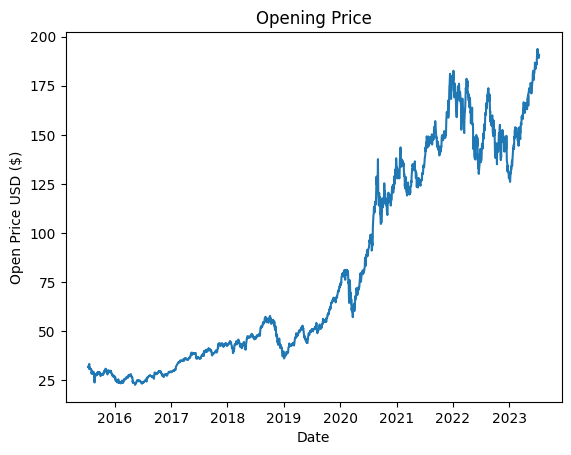

In [38]:
import matplotlib.pyplot as plt

plt.title('Opening Price')
plt.plot(apple_stock_df['Open'])
plt.xlabel('Date')
plt.ylabel('Open Price USD ($)')
plt.show()

## Calculate where to split the data

In [39]:
import numpy as np
import pandas as pd
data = apple_stock_df.filter(['Open'])

np_data = data.values

split_percent = 0.2
split_position = int(len(apple_stock_df) * (1 - split_percent))

## Scale the data

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np_data)

## Crete sequences of length 60 to feed into the LSTM

In [41]:
train_data = scaled_data[0:split_position,:]

x_train_seq =[]
y_train_seq=[]

for i in range(60, len(train_data)):
    x_train_seq.append(train_data[i-60:i,0])
    y_train_seq.append(train_data[i,0])

## Turn into numpy array and reshape it to be 3d to feed into the keras model

In [42]:
x_train, y_train = np.array(x_train_seq), np.array(y_train_seq)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1551, 60, 1)

## Create the model

In [43]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
#Build LSTM model
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

c:\Users\gdgue\Anaconda3\envs\personalProjects\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train the model

In [44]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1,epochs=4)

Epoch 1/4


1551/1551 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.0038
Epoch 2/4
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 8.8276e-04
Epoch 3/4
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 5.3956e-04
Epoch 4/4
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 4.8862e-04


## Prepare the testing data in the same way as the training

In [45]:
test_data=scaled_data[split_position-60: , : ]

x_test=[]
y_test=np_data[split_position:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

## Predict the opening stock price based. Inverse transform to get the scaled value back to the actual value

In [46]:
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


## Check how well we did using the mean squared error

In [47]:
mse =np.mean(predictions-y_test)**2
mse

1.8916432021331457

2.8849869359755544


C:\Users\gdgue\AppData\Local\Temp\ipykernel_20772\177018869.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = predictions


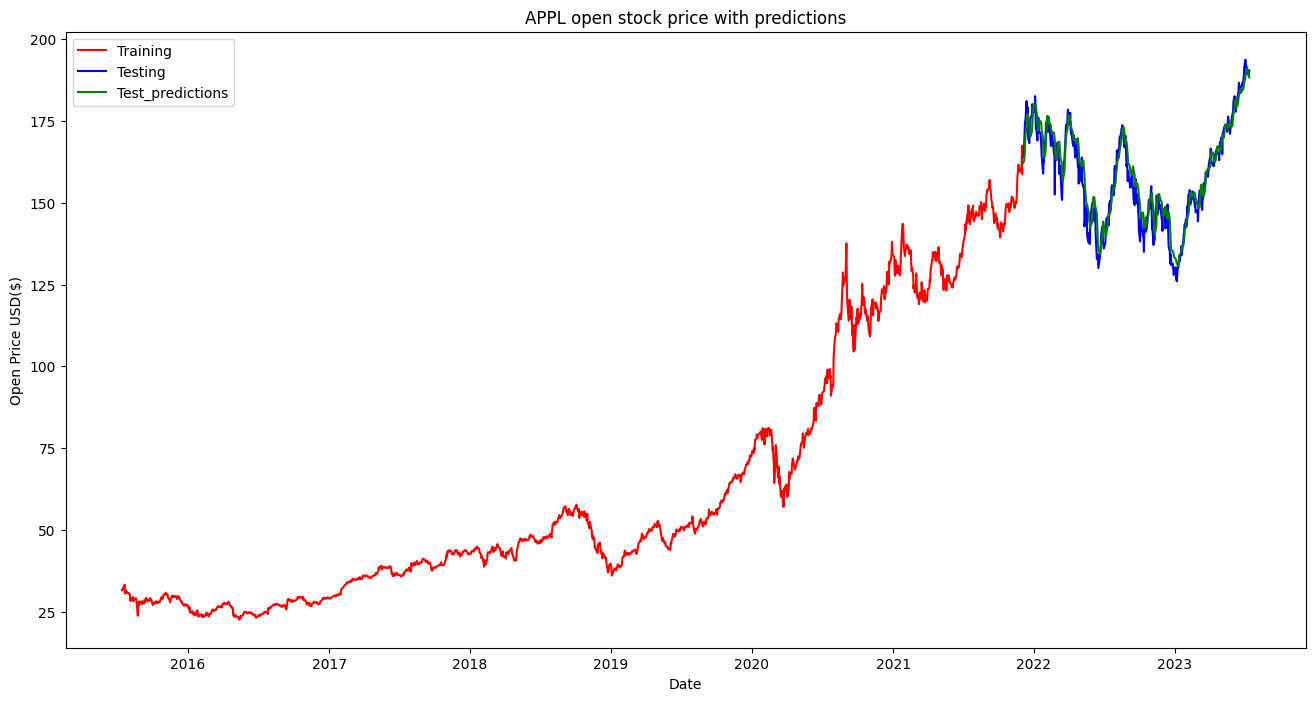

In [48]:

trained_open = data[:split_position]['Open']
test = data[split_position:]
test['predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('APPL open stock price with predictions')
plt.xlabel('Date')
plt.ylabel('Open Price USD($)')
plt.plot(trained_open, color='red')
plt.plot(test['Open'], color='blue')
plt.plot(test['predictions'] , color='green')
plt.legend(['Training','Testing', 'Test_predictions'], loc='upper left')
plt.show()

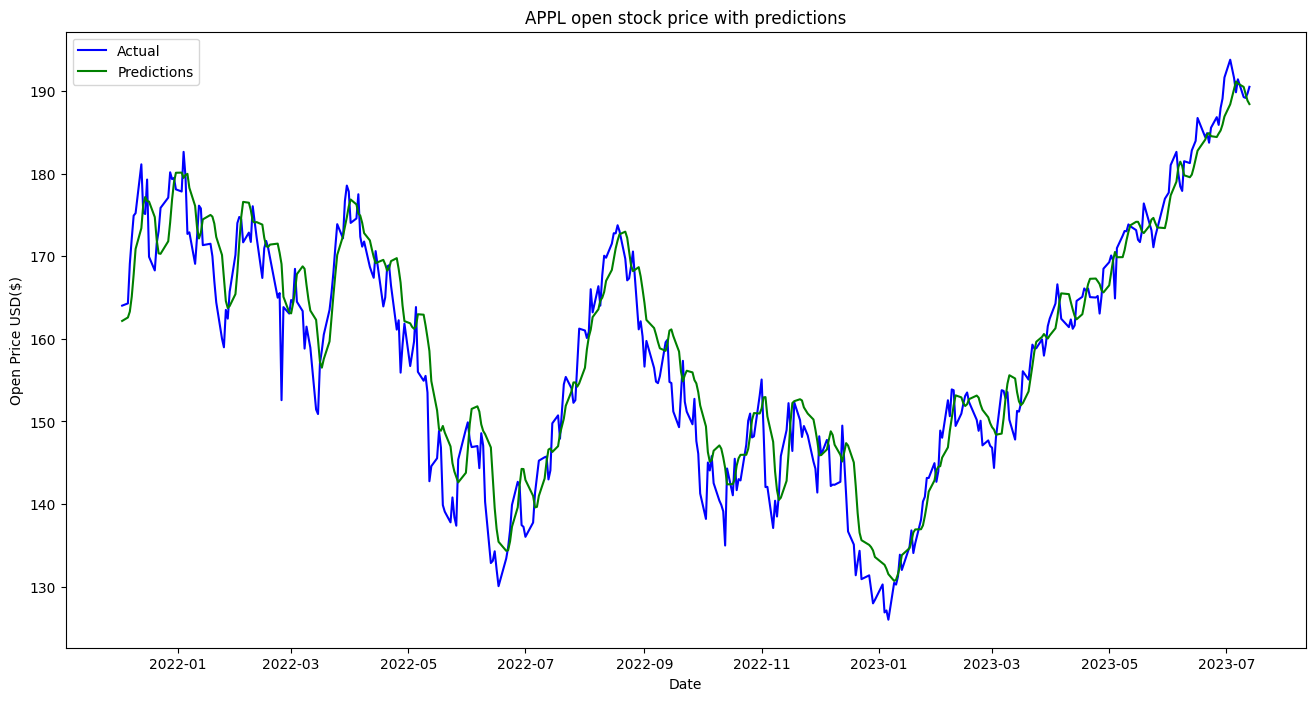

In [55]:
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('APPL open stock price with predictions')
plt.xlabel('Date')
plt.ylabel('Open Price USD($)')
plt.plot(test['Open'], color='blue')
plt.plot(test['predictions'] , color='green')
plt.legend(['Actual', 'Predictions'], loc='upper left')
plt.show()